### <strong>第四次作品：卷積神經網路 CNN 在影像辨識與超解析生成的練習 - 1 </strong>
學號：711233112

姓名：留筠雅
<hr>

 <font color=skyblue>作品目標</font>：  

本作品旨在使用卷積神經網路 (CNN) 模型對 Yale Face 資料集進行人臉辨識。具體步驟包括模型設計、訓練與測試，並最終實現對任意測試影像的人臉辨識。期望目標有：

1. CNN 模型與訓練等相關參數設定：
為了達到測試資料的辨識準確率最高，設計了一個深度卷積神經網路模型。該模型包含多個卷積層、池化層和全連接層。數據集包含不同人臉的灰度圖像。按照80%的比例進行訓練集和測試集的劃分。


2. 模型訓練過程：
模型將在訓練集上進行多輪訓練，每輪訓練後在測試集上進行評估，以挑選出最佳模型。


3. 使用訓練完成的 CNN 模型進行人臉辨識：
在模型訓練完成後，我們可以使用預訓練好的模型（存儲為pth檔）對任意一張或多張測試影像進行人臉辨識。


<hr>

導入套件

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.io
import matplotlib.pyplot as plt
import os

確定路徑

In [11]:
data_path = '.\\data\\allFaces.mat'
model_path = './cnn_model.pt'

載入與準備資料

In [ ]:
mat_contents = scipy.io.loadmat(data_path)
faces = mat_contents['faces']
m = int(mat_contents['m'])
n = int(mat_contents['n'])
nfaces = np.ndarray.flatten(mat_contents['nfaces']) #每個臉的張數
# Data usual format of sample rows and feature columns
allFaces = faces.T 
y = np.zeros((faces.shape[1], 1)) # Creating labels
M = allFaces.reshape(allFaces.shape[0], m, n)

j = 0
classes = list(range(len(nfaces)))
for i in nfaces:
    y[j:j+i] = classes.pop(0)
    j = j + i



進行深度學習時，首先需要將資料轉換成 Tensor 格式。Tensor 是一種類似於 Numpy 矩陣的資料格式，專門為 PyTorch 學習平台設計。為了有效地進行訓練並避免過度學習，還可以進一步利用 DataLoader 將 Tensor 資料分裝成小包（batch）。

In [13]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    allFaces, 
    y,
    test_size=test_size, 
    random_state=666) # deafult test_size=0.25
 
# standaredize (may not be necessary)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
 
# convert to tensors
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

X_train_ = X_train.reshape(-1, 1, m, n) # convert to N x 1 x m x n for CNN
X_test_ = X_test.reshape(-1, 1, m, n) # N x 1 x m x n
X_train_tensor = torch.tensor(X_train_, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# create dataloaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, 
                          shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, 
                         shuffle=False)


Using cuda:0 device


建立 CNN 模型：\
CNN 類別繼承自 nn.Module，並在初始化方法中定義了兩個卷積層（conv1 和 conv2）、一個最大池化層（pool）以及兩個全連接層（fc1 和 fc2）。使用前向傳播方法依次應用這些層，並使用 ReLU 激活函數和最大池化來處理輸入。接著，創建 CNN 模型並將其移動到指定的設備（GPU），定義交叉熵損失函數，最後設置 Adam 演算法當作最佳化器來更新模型的參數。

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(12, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * (m // 2) * (n // 2), 86)
        self.fc2 = nn.Linear(86, len(np.unique(y)))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * (m // 2) * (n // 2))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

 
net = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

這段程式碼首先定義了兩個列表來存訓練過程中的損失和測試的準確率。訓練迴圈包含20個訓練週期（epochs），在每個週期中，模型進入訓練模式並計算每個批次（batch）的損失，進行反向傳播以更新模型參數。每個週期結束後，將平均損失值添加到 train_losses 列表中。

在每個週期結束後，模型進入評估模式，計算在測試集上的準確率。這部分程式禁用了梯度計算以節省內存和加速計算，並將預測結果與真實標籤進行比較來計算準確率，結果添加到 test_accuracies 列表中。最後，將訓練好的模型權重保存到指定路徑 model_path 中。

In [ ]:
# Lists to store loss and accuracy values
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss/len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, \
          Loss: {running_loss/len(train_loader)}")

    # Evaluation
    net.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_images = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_images.extend(inputs.cpu().numpy())

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Accuracy: {accuracy:.2f}%")
    print("----------------------------------------------")

# Save the model
torch.save(net.state_dict(), model_path)   

輸出結果：

Epoch 1/20,           Loss: 4.907039458101446
Accuracy: 62.66%

Epoch 2/20,           Loss: 0.6166026316090556
Accuracy: 90.04%

Epoch 3/20,           Loss: 0.1337057281658823
Accuracy: 93.78%

...

Epoch 20/20,           Loss: 0.023209383849837853
Accuracy: 93.78%

<hr>

觀察討論：

每個 epoch 結束後，會輸出平均損失值 (running_loss / len(train_loader))。這有助於監控訓練過程中模型的收斂情況和效果。逐步降低的訓練損失顯示模型在訓練數據上的收斂情況。隨著訓練進行，損失應該趨於穩定或減少。從結果可以看到第一次訓練時準確率只有約 62\% 但到了最後一次準確率卻有 94\% ，而損失函數確實有隨著次數拉高而減少，整體來說在 Epoch = 3 時，收斂狀況就非常良好。


完成訓練後的神經網路模組，必須透過測試資料進行測試。因此，讀入寫好的 pre-trained pth 檔，並搭配多張測試影像觀察輸出的平均準確率。

Accuracy: 93.7759336099585%


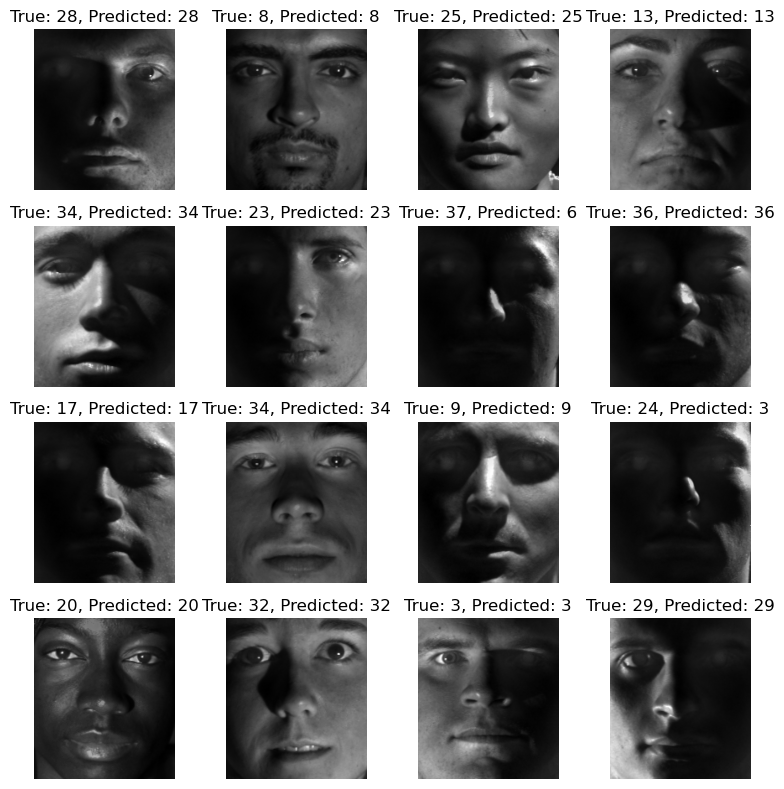

In [20]:
#讀入 pre-trained pth 檔
net = CNN().to(device)
net.load_state_dict(torch.load(model_path))
net.eval()

# Testing the model
correct = 0
total = 0
all_predictions = []
all_images = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_images.extend(inputs.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

# Visualize the predictions
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i in range(16):
    ax[i//4, i%4].imshow(all_images[i].squeeze().T, cmap='gray')
    ax[i//4, i%4].set_title(
        f"True: {int(y_test[i])}, Predicted: {all_predictions[i]}",
          fontsize=12)
    ax[i//4, i%4].axis('off')
    


plt.tight_layout()
plt.show()



觀察討論：

測試資料的準確率有 94\% 。觀察圖片可發現除了陰影面較重的人像模型有可能會預測錯誤(第二排第三位、第三排第四位)，其餘皆預測正確，模型表現良好。